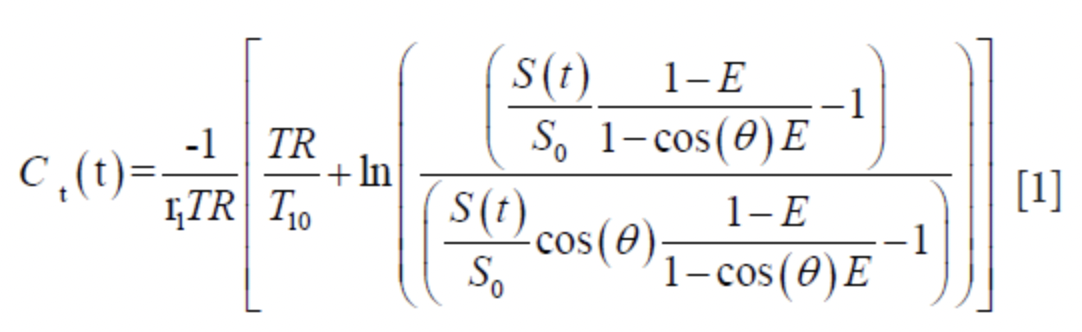

In [115]:
import os
import pydicom
import numpy as np
import subtle.utils.io as suio
import subtle.subtle_preprocess as supre
import matplotlib.pyplot as plt
import math
from glob import glob
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

#Gd-DOTA r1 average is 3.4 s-1.mM-1 according to https://sci-hub.se/10.1097/RLI.0000000000000132

def solve_conc_eqn(st_post, st_pre, ecos_ratio, theta, trm1, trm2):
    trm3_num = ((st_post/st_pre) * ecos_ratio) - 1
    trm3_den = ((st_post/st_pre) * np.cos(theta) * ecos_ratio) - 1
    trm3 = math.log(np.abs(trm3_num / trm3_den))

    return trm1 * (trm2 + trm3)

def get_dcm_ser_nums(dpath_root):
    dcm_sers = [d for d in glob('{}/*'.format(dpath_root))]
    ser_nums = []
    for dpath in dcm_sers:
        fp_dcms = [f for f in glob('{}/*.dcm'.format(dpath))]
        dcm = pydicom.dcmread(fp_dcms[0])
        ser_nums.append((dpath, int(dcm.SeriesNumber)))
    ser_nums = sorted(ser_nums, key=lambda r:r[1])
    return ser_nums

def scale_with_dcm_tags(img, img_hdr):
    rs = float(img_hdr.RescaleSlope)
    ri = float(img_hdr.RescaleIntercept)
    ss = img_hdr[0x2005, 0x100e].value
    img = supre.scale_slope_intercept(img, rs, ri, ss)
    return img
    
def get_gd_conc(dpath_data, dpath_meta, case_num, file_ext='h5', r1=3.4):
    dpath_case_dcm = os.path.join(dpath_meta, case_num)
    snum_series = get_dcm_ser_nums(dpath_case_dcm)
    
    pre, pre_hdr = suio.dicom_files(snum_series[0][0])
    pre = scale_with_dcm_tags(pre, pre_hdr)

    low, low_hdr = suio.dicom_files(snum_series[1][0])
    low = scale_with_dcm_tags(low, low_hdr)
    
    full, full_hdr = suio.dicom_files(snum_series[2][0])
    full = scale_with_dcm_tags(full, full_hdr)
    
    fpath_dcm = [f for f in glob('{}/{}/**/*.dcm'.format(dpath_meta, case_num))][0]
    dcm_meta = pydicom.dcmread(fpath_dcm)
    
    T_10 = 1.3 if float(dcm_meta.MagneticFieldStrength) == 3.0 else 0.9
    TR = float(dcm_meta.RepetitionTime)
    theta = float(dcm_meta.FlipAngle)
    E = math.exp(-TR/T_10)
    
    st_pre = pre.mean()
    st_low = low.mean()
    st_full = full.mean()
    
    trm1 = 1.0/(r1*TR)
    trm2 = TR/T_10
    
    er_num = (1-E)
    er_den = (1 - np.cos(theta)*E)
    ecos_ratio = er_num/er_den
    
    c_low = solve_conc_eqn(st_low, st_pre, ecos_ratio, theta, trm1, trm2)
    c_full = solve_conc_eqn(st_full, st_pre, ecos_ratio, theta, trm1, trm2)
    
    return {
        'low': np.abs(c_low),
        'full': np.abs(c_full)
    }

<Figure size 864x720 with 0 Axes>

In [94]:
dpath_data = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data'
dpath_meta = '/home/srivathsa/projects/studies/gad/tiantan/data'

cases = sorted([
    c.split('/')[-1].replace('.h5', '') 
    for c in glob('{}/*'.format(dpath_data)) 
    if ('Brain' in c or 'NO' in c or 'Prisma' in c) and 'meta' not in c
])

fdose = 0.1
cases = ['NO1']
for cnum in cases:
    try:
        conc = get_gd_conc(dpath_data, dpath_meta, cnum)
        low_pct = (conc['low']/fdose) * 100
        full_pct = (conc['full']/fdose) * 100
        print('{}-{:03f},{:03f}'.format(cnum, conc['low'], conc['full']))
    except Exception as exc:
        print('ERROR in {}:{}'.format(cnum, exc))

0.9927918013372365 8.0 0.04464648541430747 5.067461453951315
0.9927918013372365 8.0 0.04464648541430747 5.067461453951315
NO1-0.312304,0.312304


In [167]:
dpath_meta = '/home/srivathsa/projects/studies/gad/tiantan/data'
case_num = 'NO1'

dpath_case_dcm = os.path.join(dpath_meta, case_num)
snum_series = get_dcm_ser_nums(dpath_case_dcm)

pre, pre_hdr = suio.dicom_files(snum_series[0][0])
pre = scale_with_dcm_tags(pre, pre_hdr)

low, low_hdr = suio.dicom_files(snum_series[1][0])
low = scale_with_dcm_tags(low, low_hdr)

full, full_hdr = suio.dicom_files(snum_series[2][0])
full = scale_with_dcm_tags(full, full_hdr)

In [168]:
data_full = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO1.h5', params={'h5_key': 'all'})
mask = (data_full[1, :, 0] > 0).astype(np.uint8)

pre = pre * mask
low = low * mask
full = full * mask
# up_mask = (full - pre)
# th = up_mask.max() * 0.05
# up_mask = (up_mask > th).astype(np.uint8)

# pre = pre * up_mask
# low = low * up_mask
# full = full * up_mask

In [169]:
print(pre.min(), pre.max(), pre.mean())
print(low.min(), low.max(), low.mean())
print(full.min(), full.max(), full.mean())

0.0 109593.625 5655.897
0.0 240932.69 5193.7046
0.0 368512.7 5943.4136


In [170]:
print(pre[np.nonzero(pre)].mean())
print(low[np.nonzero(low)].mean())
print(full[np.nonzero(full)].mean())

44839.742
41176.645
47120.047


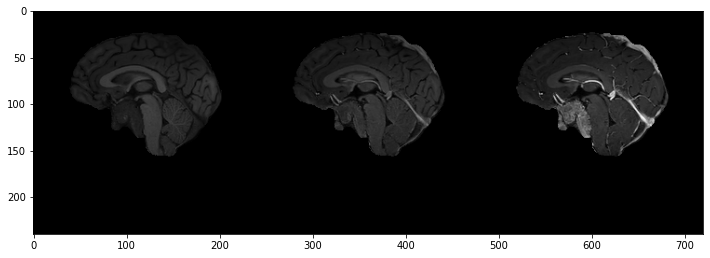

In [171]:
plt.imshow(np.hstack([pre[98], low[98], full[98]]))

In [129]:
print(pre.mean(), low.mean(), full.mean())

421.55252 701.4173 1275.7811


In [179]:
solve_conc_eqn(0.77, 1.007, 0.9927918013372365, 8.0, 0.04464648541430747, 5.067461453951315)

0.15801152578373018

In [176]:
pre, low, full = data_full[0].transpose(1, 0, 2, 3)

In [177]:
print(pre.min(), pre.max(), pre.mean())
print(low.min(), low.max(), low.mean())
print(full.min(), full.max(), full.mean())

0.0 8.8396015 0.7780236
0.0 8.213942 1.0060322
0.0 8.042492 1.0074583
